In [1]:
!pip install networkx numpy pandas torch torchvision torch-geometric matplotlib annoy

In [2]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from annoy import AnnoyIndex

data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [4]:
G1 = nx.Graph()

# Add nodes for cardholders and transactions
for ith, row in data.iterrows():
    transaction_node = f"cardholder_{ith}"
    G1.add_node(transaction_node, type='transaction', amount=row['Amount'], time=row['Time'], label=row['Class'])

f = 30
amount_index = AnnoyIndex(f, 'angular')

for i, row in data.iterrows():
    amount_index.add_item(i, row.values[:-1])

amount_index.build(100)
# sim_threshold=5

for i in range(len(data)):
    neighbors = amount_index.get_nns_by_item(i, 1, include_distances=True)
    for neighbor_index, dist in zip(neighbors[0], neighbors[1]):
        if i!=neighbor_index:
            transaction_node_i = f"cardholder_{i}"
            transaction_node_j = f"cardholder_{neighbor_index}"
            G1.add_edge(transaction_node_i, transaction_node_j, weight=dist)


print(f'Number of nodes: {G1.number_of_nodes()}')
print(f'Number of edges: {G1.number_of_edges()}')

Number of nodes: 284807
Number of edges: 276502


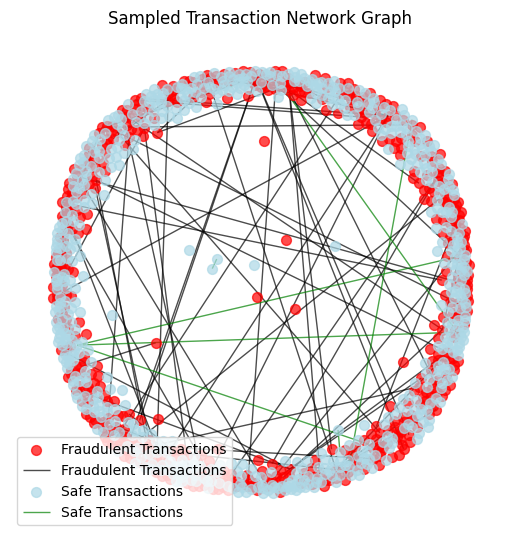

In [5]:
class_1_nodes = [u for u, data in G1.nodes(data=True) if data['label']==1][:500]
class_0_nodes = [u for u, data in G1.nodes(data=True) if data['label']==0][:600]


G_subsampled = G1.subgraph(class_0_nodes+class_1_nodes).copy()
G_class_1 = G1.subgraph(class_1_nodes).copy()
G_class_0 = G1.subgraph(class_0_nodes).copy()

plt.figure(figsize=(5, 5))
pos=nx.spring_layout(G_subsampled, seed=42)
nx.draw(G_class_1, pos, with_labels=False, node_size=50, node_color='red', edge_color='black', alpha=0.7, label="Fraudulent Transactions")
nx.draw(G_class_0, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='green', alpha=0.7, label="Safe Transactions")
plt.title('Sampled Transaction Network Graph')
plt.legend(loc='lower left')
plt.show()

In [6]:
# edges_class1 = [(u,v) for u, v, data in G.edges(data=True) if data.get('label')==1][0:100]
# edges_class0 = [(u,v) for u, v, data in G.edges(data=True) if data.get('label')==0][0:100]

# G_class_1 = G.edge_subgraph(edges_class1).copy()
# G_class_0 = G.edge_subgraph(edges_class0).copy()
# plt.figure(figsize=(5, 5))
# pos1=nx.spring_layout(G_class_1, seed=42)
# pos0=nx.spring_layout(G_class_0, seed=42)
# nx.draw(G_class_1, pos1, with_labels=False, node_size=50, node_color='red', edge_color='black', alpha=0.7, label="Fraudulent Transactions")
# nx.draw(G_class_0, pos0, with_labels=False, node_size=50, node_color='lightblue', edge_color='green', alpha=0.7, label="Safe Transactions")
# plt.title('Sampled Transaction Network Graph')
# plt.legend()
# plt.show()


In [7]:
G = G_subsampled

In [8]:
from torch_geometric.data import Data

nodes = list(G.nodes())
node_map = {node: i for i, node in enumerate(nodes)}

edge_index = torch.tensor([[node_map[u], node_map[v]] for u,v in G.edges()], dtype=torch.long).t().contiguous()
edge_attr = torch.tensor([G[u][v]['weight'] for u,v in G.edges], dtype=torch.float).view(-1,1)
y = torch.tensor([data['label'] for u, data in G.nodes(data=True)], dtype=torch.long)
x = torch.tensor([[data['amount'], data['time']] for u, data in G.nodes(data=True)], dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, batch=len(y))

In [9]:
print(x.shape, len(y))

torch.Size([1092, 2]) 1092


In [14]:
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=2, out_channels=64)
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
#         self.conv3 = GCNConv(in_channels=64, out_channels=32)
        self.fc1 = torch.nn.Linear(32,16)
        self.fc2 = torch.nn.Linear(16,2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = torch.relu(x)
#         x = self.conv3(x, edge_index, edge_attr)
#         x = torch.relu(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

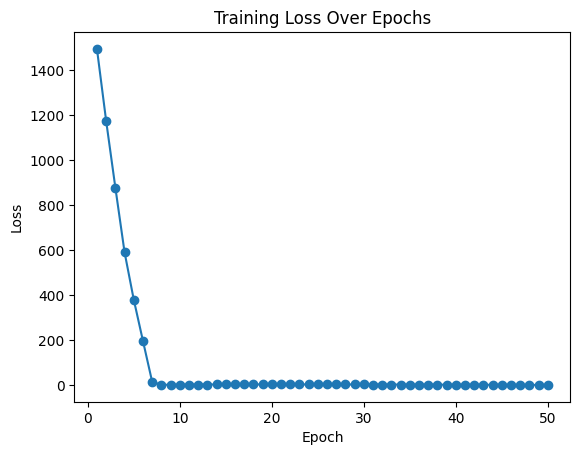

Accuracy: 0.78
F1 Score: 0.80


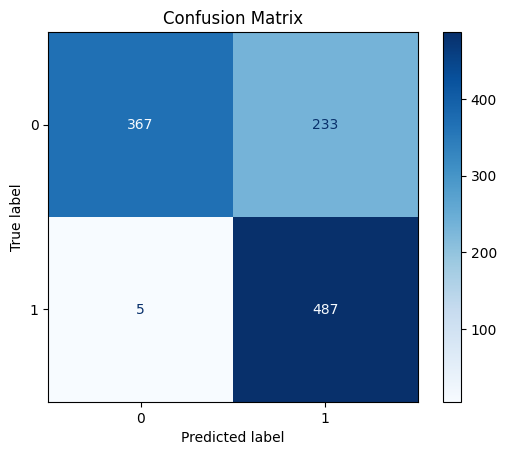

In [17]:
# Initialize model, loss, and optimizer
model = GNNModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track and plot training loss
losses = []
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    accuracy = correct / len(data.y)
    print(f'Accuracy: {accuracy:.2f}')
    
    
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

cm = confusion_matrix(data.y.numpy(), pred.numpy())
f1 = f1_score(data.y.numpy(), pred.numpy())

# Print results
# print("Confusion Matrix:")
# print(cm)
print(f"F1 Score: {f1:.2f}")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [12]:
class GATModel(torch.nn.Module):
    def __init__(self):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels=2, out_channels=16, heads=1, dropout=0.3)
        self.conv2 = GATConv(in_channels=16, out_channels=32, heads=1, dropout=0.3)
        self.conv3 = GATConv(in_channels=32, out_channels=64, heads=1, dropout=0.3)
        self.fc1 = torch.nn.Linear(64,16)
        self.fc2 = torch.nn.Linear(16,2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

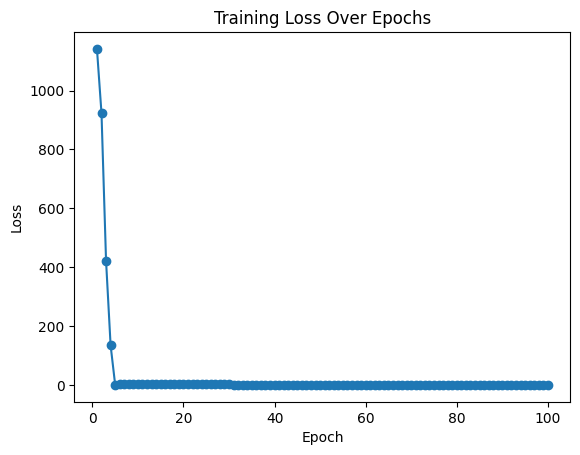

Accuracy: 0.80
F1 Score: 0.82


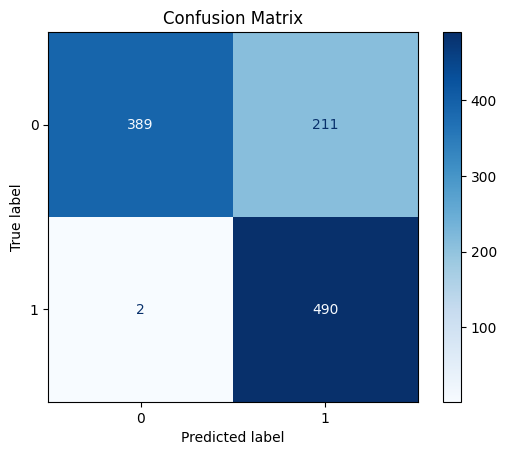

In [21]:
# Initialize model, loss, and optimizer
model = GATModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track and plot training loss
losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    accuracy = correct / len(data.y)
    print(f'Accuracy: {accuracy:.2f}')
    
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

cm = confusion_matrix(data.y.numpy(), pred.numpy())
f1 = f1_score(data.y.numpy(), pred.numpy())

# Print results
# print("Confusion Matrix:")
# print(cm)
print(f"F1 Score: {f1:.2f}")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()